Data load, set your target and unsused_features

train data and valida data would be 75% and 25% of train data.

In [32]:
!git remote add git@github.com:gunahn/bandgap.git


fatal: not a git repository (or any of the parent directories): .git


In [30]:
!git remote add origin git@github.com:gunahn/bandgap.git
!git branch -M main
!git push -u origin main

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


In [3]:
from torch import nn
import torch
from torch import tensor 
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.metrics import roc_auc_score

train= pd.read_csv('Training_Set.csv')
#df = pd.read_csv('./data/my.nih.norm.csv')
#df1 = pd.read_csv('./data/abcd_tbss01.csv')


In [16]:
train = train.fillna(0).reset_index(drop=True)

train.dtypes

Composition                          object
Eg                                  float64
class                                 int64
avg_Atomic number                   float64
avg_Atomic weight                   float64
                                     ...   
min_Thermal conductivity (W/m?K)    float64
min_Heat atomization (kJ/mol)         int64
min_Cohesive energy (eV)            float64
Unnamed: 139                        float64
Set                                  object
Length: 141, dtype: object

In [17]:
target = 'class'
unused_feat = ['Composition', 'Set', 'Eg']
features = [ col for col in train.columns if col not in unused_feat + [target]] 


if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [18]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]
X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]
X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

print("X_train.shape: ", X_train.shape)
print("y_train.shape: ",y_train.shape)
print("X_valid.shape: ", X_valid.shape)
print("y_valid.shape: ",y_valid.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ",y_test.shape)

X_train.shape:  (3951, 137)
y_train.shape:  (3951,)
X_valid.shape:  (471, 137)
y_valid.shape:  (471,)
X_test.shape:  (494, 137)
y_test.shape:  (494,)


In [19]:
print("X_train.shape: ", X_train)
print("y_train.shape: ",y_train)
print("X_valid.shape: ", X_valid)
print("y_valid.shape: ",y_valid)
print("X_test.shape: ", X_test)
print("y_test.shape: ",y_test)

X_train.shape:  [[ 50.57142857 121.7476314    5.         ... 112.           1.16
    0.        ]
 [ 50.57142857 121.7018643    5.         ... 112.           1.16
    0.        ]
 [ 50.53900709 121.6169773    5.         ... 112.           1.16
    0.        ]
 ...
 [ 23.          50.74585      3.75       ... 249.           2.62
    0.        ]
 [ 14.5         31.63680225   2.625      ...  79.           0.84
    0.        ]
 [ 62.66666667 152.968        5.66666667 ... 609.           6.25
    0.        ]]
y_train.shape:  [1 1 1 ... 0 0 0]
X_valid.shape:  [[ 24.36363636  52.95372036   3.54545455 ... 112.           1.16
    0.        ]
 [ 21.9047619   49.68028      3.         ... 107.           1.11
    0.        ]
 [ 28.          63.52015583   3.5        ... 107.           1.11
    0.        ]
 ...
 [ 33.33333333  74.1758       4.33333333 ... 377.           3.85
    0.        ]
 [ 35.6         81.289        4.4        ... 609.           6.25
    0.        ]
 [ 45.5        106.492        5.

In [20]:
# Augmented
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm
# Store maximum auc
max_auc = 0
# Store maximum hypterparameter set
max_hy = []
# define hyperparameter space
n_ = [4,8,16]
lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
w_ = [0.01, 0.001, 0.0001]
g_ = [0.95, 0.99, 0.9]
ss_ = [10, 20, 30]
all_ = [n_, lr_, w_, g_, ss_]
h_space = [s for s in itertools.product(*all_)]
# Start training


for hy in tqdm(h_space):
    clf = TabNetClassifier(n_a = hy[0],
                           n_d = hy[0],
                           optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                           scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           verbose=0
                           )
    clf.fit(X_train, y_train, X_valid, y_valid, patience=50, batch_size=256, max_epochs=200)
    preds_acc = clf.predict(X_test)
    preds_prob = clf.predict_proba(X_test)
    test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=y_test)
    test_acc = accuracy_score(preds_acc, y_test)
    print("FINAL TEST SCORE", test_auc, test_acc)
    if test_auc>max_auc:
        max_hy = hy
        max_auc = test_auc


Device used : cuda
FINAL TEST SCORE 0.9409604380830587 0.8562753036437247
Device used : cuda
FINAL TEST SCORE 0.9401242765563261 0.854251012145749
Device used : cuda
FINAL TEST SCORE 0.9519453051989573 0.8461538461538461
Device used : cuda
FINAL TEST SCORE 0.9447313626153822 0.8603238866396761
Device used : cuda
FINAL TEST SCORE 0.9455675241421145 0.8562753036437247
Device used : cuda
FINAL TEST SCORE 0.9302378961520175 0.8360323886639676
Device used : cuda
FINAL TEST SCORE 0.9561589034807273 0.8927125506072875
Device used : cuda
FINAL TEST SCORE 0.9306149886052499 0.8582995951417004
Device used : cuda
FINAL TEST SCORE 0.9455511288180611 0.8724696356275303
Device used : cuda
FINAL TEST SCORE 0.9603069204662831 0.9008097165991903
Device used : cuda
FINAL TEST SCORE 0.9665371436066433 0.917004048582996
Device used : cuda
FINAL TEST SCORE 0.9612578492613907 0.9109311740890689
Device used : cuda
FINAL TEST SCORE 0.9588149459774072 0.902834008097166
Device used : cuda
FINAL TEST SCORE 0.963

In [21]:
hy = max_hy
clf = TabNetClassifier(n_a = hy[0],
                           n_d = hy[0],
                           optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                           scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           verbose=0
                           )
clf.fit(X_train, y_train, X_valid, y_valid, patience=50, batch_size=256, max_epochs=200)
preds_acc = clf.predict(X_test)
preds_prob = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=y_test)
test_acc = accuracy_score(preds_acc, y_test)
print("max_hy: " ,hy)
print("FINAL TEST SCORE", test_auc, test_acc)
    

Device used : cuda
max_hy:  (4, 0.02, 0.001, 0.9, 20)
FINAL TEST SCORE 0.9719967865164856 0.9291497975708503


,feature name,ratio
0,avg_Number of p electrons,0.289273
1,min_L quantum number,0.112694
2,max_Metallic valence,0.072366
3,diff_First ionization energy (kJ/mol),0.062569
4,avg_Boiling point (K),0.045361
5,diff_Number of p electrons,0.043496
6,diff_Group number,0.043010
7,avg_Allen EN,0.042153
8,diff_Density (g/mL),0.039878
9,avg_Heat of vaporization (kJ/mol),0.038749


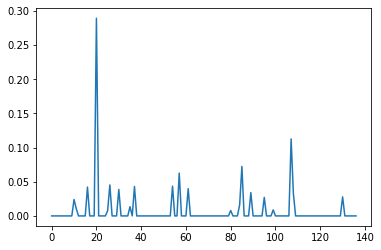

In [28]:
importance =clf.feature_importances_
plt.plot(importance)

labels_importance=importance.argsort()[::-1]

importance_sort = np.sort(importance)[::-1]

feat_name_sort=train[features].columns[labels_importance]
important_features = pd.DataFrame() 


for i in range (10):
    feature = pd.DataFrame([[feat_name_sort[i],importance_sort[i]]], columns = ['feature name', 'ratio'])
    important_features=pd.concat([important_features,feature])

important_features.reset_index(drop=True)

In [59]:
from sklearn.model_selection import KFold
NUM_FOLDS = 5  # you can specify your folds here

# Creating FOLDS

test_data_processed["kfold"] = -1

train_data_processed["kfold"] = -1

train_data_processed = train_data_processed.sample(frac=1,random_state=2020).reset_index(drop=True)

kf = KFold(n_splits=NUM_FOLDS)

for fold, (trn_, val_) in enumerate(kf.split(X=train_data_processed, y=train_data_processed)):
    train_data_processed.loc[val_, 'kfold'] = fold
    
train_data_processed

,Unnamed: 0,subjectkey,sex,race.ethnicity,abcd_site,lh_bankssts_area._.1,lh_caudalanteriorcingulate_area._.1,lh_caudalmiddlefrontal_area._.1,lh_cuneus_area._.1,lh_entorhinal_area._.1,...,wm.rh.transversetemporal._.18,wm.rh.insula._.18,Left.UnsegmentedWhiteMatter._.18,Right.UnsegmentedWhiteMatter._.18,lhCerebralWhiteMatterVol._.18,rhCerebralWhiteMatterVol._.18,CerebralWhiteMatterVol._.18,MaskVol._.18,EstimatedTotalIntraCranialVol._.18,kfold
0,5258,NDAR_INVH1DJ48J1,1,1,11,0.995173,1.096158,3.477764,1.166651,-0.589630,...,-0.828231,1.227477,1.750053,1.565132,1.631344,1.573952,1.604291,1.629750,1.444491,0
1,1667,NDAR_INV57CKHLC8,1,3,3,0.038717,-0.522494,-0.909285,-1.074445,-0.685008,...,1.342644,-0.179764,-0.925164,-0.686693,-1.027205,-0.920787,-0.974965,-0.740189,-0.236888,0
2,4333,NDAR_INVDZLD38UM,2,3,10,-0.046412,-0.502593,-0.002720,0.520982,-1.867698,...,-0.698690,1.028569,-0.212771,-0.051552,-0.207165,-0.240379,-0.224018,-0.060954,-0.505478,0
3,4979,NDAR_INVG270KBWC,1,1,13,-0.552182,-0.927157,-0.900174,-1.078611,-0.704084,...,5.567552,0.719304,-0.229947,-0.250116,-0.075780,-0.025129,-0.050486,-0.846273,-0.822425,0
4,3629,NDAR_INVBLYFK2HJ,1,2,1,0.925066,-1.066467,-0.362613,-1.395197,-1.696018,...,1.167382,-0.962313,-1.103856,-1.130861,-1.167459,-1.086792,-1.128264,-1.030148,-1.191267,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7819,6538,NDAR_INVM2JLZJJ1,2,4,1,-1.077982,-1.099636,-1.599460,-0.062203,-1.629253,...,1.397678,-0.202992,-0.791601,-1.215579,-0.851700,-1.124041,-0.989011,-0.940313,-0.772565,4
7820,7159,NDAR_INVP7PFH5GK,1,3,1,1.135386,-1.683412,-1.241845,-1.366037,-0.704084,...,0.103958,-0.595878,-0.036227,-0.455683,-0.877917,-0.870463,-0.875096,-0.697011,-1.274056,4
7821,8027,NDAR_INVTYTK28UK,1,1,21,0.274075,0.810904,-0.036887,1.741504,1.174867,...,1.499279,1.518349,0.251369,0.198816,0.961198,0.994185,0.978722,1.254736,1.320461,4
7822,5325,NDAR_INVH7TVMCPN,2,1,11,-0.992853,-0.230606,-0.979897,1.270791,0.907808,...,-0.481941,0.271619,-2.229720,-2.280253,-1.149105,-1.184561,-1.168061,-0.669032,-0.308014,4


In [60]:

target='sex'
unused_feat = ['Set', 'subjectkey', 'race.ethnicity', 'abcd_site', 'Unnamed: 0']

features = [ col for col in train_data_processed.columns if col not in unused_feat + [target]] 


In [67]:
X_test = test_data_processed[features].values
Y_test = test_data_processed[target].values

def run(fold):
    df_train = train_data_processed[train_data_processed.kfold != fold]
    df_valid = train_data_processed[train_data_processed.kfold == fold]
    
    X_train = df_train[features].values
    Y_train = df_train[target].values
    
    X_valid = df_valid[features].values
    Y_valid = df_valid[target].values
    
    y_oof = np.zeros((df_valid.shape[0],len(target)))   # Out of folds validation
    
    print("--------Training Begining for fold {}-------------".format(fold+1))
    n_ = [4,8,16]
    lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99, 0.9]
    ss_ = [10, 20, 30]
    all_ = [n_, lr_, w_, g_, ss_]
    h_space = [s for s in itertools.product(*all_)]
# Start training
    hy=h_space[0]
    
    clf = TabNetClassifier(n_a = hy[0],
                       n_d = hy[0],
                       optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                       scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       verbose=0
                           )
    clf.fit(X_train, Y_train, X_valid, Y_valid, patience=50, batch_size=256, max_epochs=200)
    preds_acc = clf.predict(X_test)
    preds_prob = clf.predict_proba(X_test)
    test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=Y_test)
    test_acc = accuracy_score(preds_acc, Y_test)
    print("FINAL TEST SCORE", test_auc, test_acc)

    # VISUALIZTION
    #plt.figure(figsize=(12,6))
    #plt.plot(model.history['train']['loss'])
    #plt.plot(model.history['valid']['loss'])
    
    #Plotting Metric
    #plt.plot([-x for x in model.history['train']['metric']])
    #plt.plot([-x for x in model.history['valid']['metric']])

In [68]:
run(fold=0)

--------Training Begining for fold 1-------------
Device used : cuda
FINAL TEST SCORE 0.9319991637484973 0.8349514563106796


--------Training Begining for fold 1-------------
Device used : cuda
FINAL TEST SCORE 0.9319991637484973 0.8349514563106796
                       feature name     ratio
0      lhCerebralWhiteMatterVol._.9  0.201582
1            BrainSegVolNotVent._.4  0.200428
2    rh_G_temporal_middle_area._.14  0.086167
3  rh_S_oc_middle.Lunatus_area._.14  0.085094
4          rh_S_front_sup_area._.14  0.064803
--------Training Begining for fold 2-------------
Device used : cuda
FINAL TEST SCORE 0.9338640045993832 0.7812979049565661
                       feature name     ratio
0      lhCerebralWhiteMatterVol._.9  0.201582
1            BrainSegVolNotVent._.4  0.200428
2    rh_G_temporal_middle_area._.14  0.086167
3  rh_S_oc_middle.Lunatus_area._.14  0.085094
4          rh_S_front_sup_area._.14  0.064803
--------Training Begining for fold 3-------------
Device used : cuda
FINAL TEST SCORE 0.930464642241154 0.8277976494634645
                       feature name     ratio
0      lhCerebralWhiteMatterVol

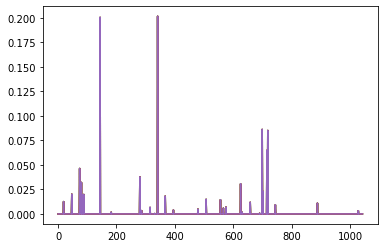

In [71]:
for i in range(NUM_FOLDS):
    run(fold = i)
    feature(5)

Do it with best hyperparameter 

find feature importance 

In [70]:
# 위에서 부터 랭킹 찾고 싶은 숫자

def feature(num):
    importance =clf.feature_importances_
    plt.plot(importance)

    labels_importance=importance.argsort()[::-1]

    importance_sort = np.sort(importance)[::-1]

    feat_name_sort=test_data_processed[features].columns[labels_importance]
    important_features = pd.DataFrame() 


    for i in range (num):
        feature = pd.DataFrame([[feat_name_sort[i],importance_sort[i]]], columns = ['feature name', 'ratio'])
        important_features=pd.concat([important_features,feature])

    print(important_features.reset_index(drop=True))
